In [34]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import pandas as pd
from parameters import params

#prepairing connection to database
engine = create_engine(params).connect()
#allows querying database(pulling data)
session = Session(engine)
#reflect the tables in the database
Base = automap_base()
Base.prepare(engine, reflect=True)
#mapped classes are created with default matching of the table names
epi_country = Base.classes.epi_country
#a query with filtering and selection of specific columns
result = session.query(epi_country.air_h, epi_country.country, epi_country.envhealth,epi_country.epi, epi_country.epi_regions, epi_country.fisheries, epi_country.forestry,epi_country.water_h).filter(epi_country.epi != None)
#converting query to dataframe
epi_df = pd.read_sql(result.statement, engine)


/var/folders/kc/j4ss26096jv9xkwkcr7z36kr0000gn/T/ipykernel_48926/1575953482.py:13: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [35]:
epi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   air_h        163 non-null    float64
 1   country      163 non-null    object 
 2   envhealth    163 non-null    float64
 3   epi          163 non-null    float64
 4   epi_regions  163 non-null    object 
 5   fisheries    163 non-null    float64
 6   forestry     163 non-null    float64
 7   water_h      163 non-null    float64
dtypes: float64(6), object(2)
memory usage: 10.3+ KB


In [36]:
#Chose Corruption Perceptions Index dataset in order to see if there is a correlation with Environmental Performance index
cpi_df = pd.read_csv('CPI-2010-new_200601_105629.csv', na_filter=True)
cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   country   178 non-null    object 
 1   iso       178 non-null    object 
 2   region    178 non-null    object 
 3   score     178 non-null    float64
 4   rank      178 non-null    int64  
 5   interval  178 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 8.5+ KB


In [37]:
#Filtered epi_df by epi_regions instead of GEO_subregeon to include more countries into dataframe
#Chose three regions with the highest numbers of countries available
reg_list = ["Latin America and Caribbean","Europe","Sub-Saharan Africa" ]
epi_three = epi_df[epi_df["epi_regions"].isin(reg_list)]

In [13]:
#Combined two data frames epi_three and cpi_df on country
joined = pd.merge(epi_three, cpi_df, how='inner', on = 'country')

In [14]:
joined.columns

Index(['air_h', 'country', 'envhealth', 'epi', 'epi_regions', 'fisheries',
       'forestry', 'water_h', 'iso', 'region', 'score', 'rank', 'interval'],
      dtype='object')

In [16]:
#lost some entries while joining dataframes,some countries' names were stored differently in each dataset
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 90
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   air_h        91 non-null     float64
 1   country      91 non-null     object 
 2   envhealth    91 non-null     float64
 3   epi          91 non-null     float64
 4   epi_regions  91 non-null     object 
 5   fisheries    91 non-null     float64
 6   forestry     91 non-null     float64
 7   water_h      91 non-null     float64
 8   iso          91 non-null     object 
 9   region       91 non-null     object 
 10  score        91 non-null     float64
 11  rank         91 non-null     int64  
 12  interval     91 non-null     object 
dtypes: float64(7), int64(1), object(5)
memory usage: 10.0+ KB


In [17]:
#decided to rename score into cpi - Corruption Perceptions Index
joined.rename(columns = {'score':'cpi'}, inplace = True)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

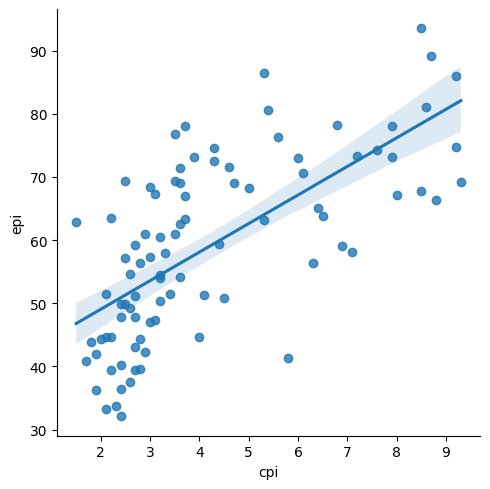

In [38]:
sns.lmplot( x ='cpi', y = 'epi', data=joined);
plt.show()

From the plot above we can infer that the better some contry handles corruption, the higher its environmental performance index is

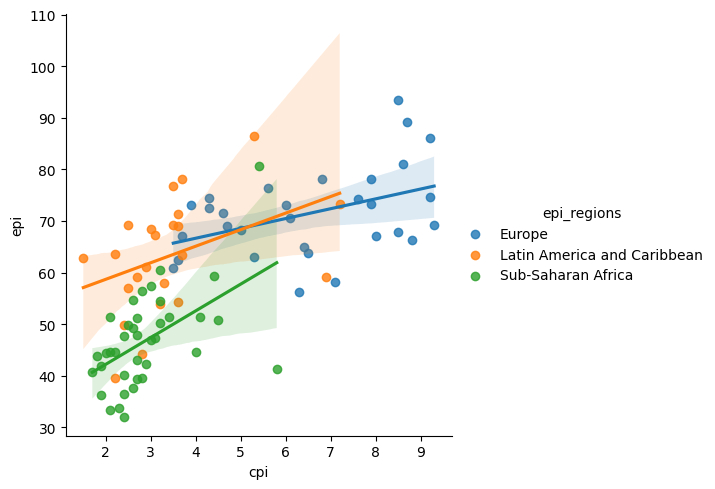

In [39]:
sns.lmplot( x ='cpi', y = 'epi', hue = "epi_regions", data=joined);
plt.show()

The correlation between cpi and epi is not as clear if we divide the graph into regions, however the connection is still noticeble

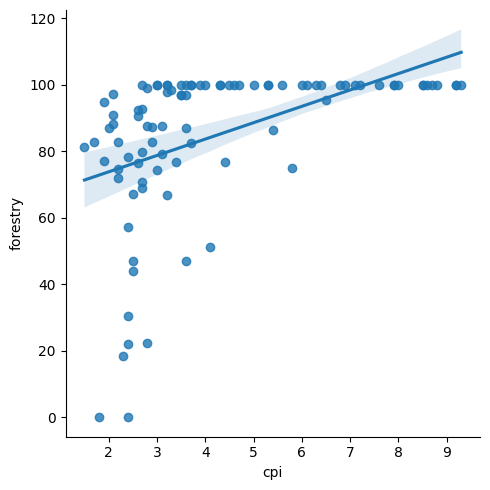

In [40]:
sns.lmplot( x ='cpi', y = 'forestry', data=joined);
plt.show()

From the graph above we see that there are a lot of countries with high forestry index, but low cpi.
From that we can infer that high corruption levels not always indicate low indeces on environmental categories

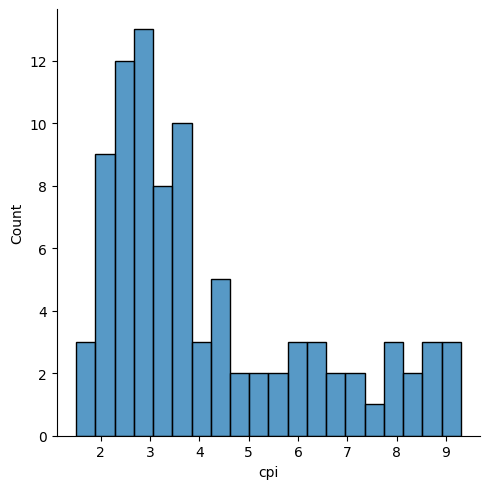

In [41]:
sns.displot(joined,x='cpi', bins = 20);

Distribution of cpi scores is positively skewed

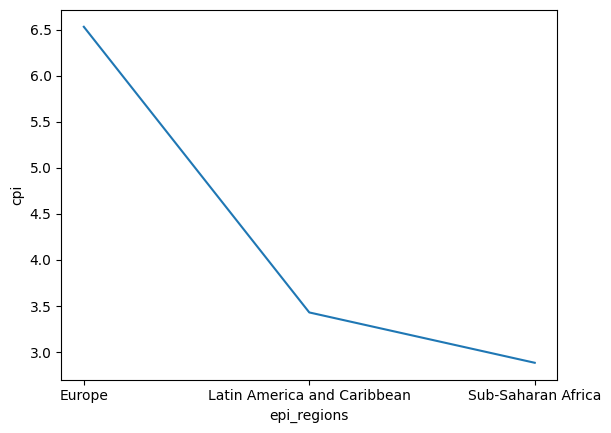

In [42]:
sns.lineplot(x = 'epi_regions', y = 'cpi', data=joined.groupby('epi_regions')['cpi'].mean().to_frame());

From the graph above we can infer that European countries on average handle corruption better that the countries from the other two regions

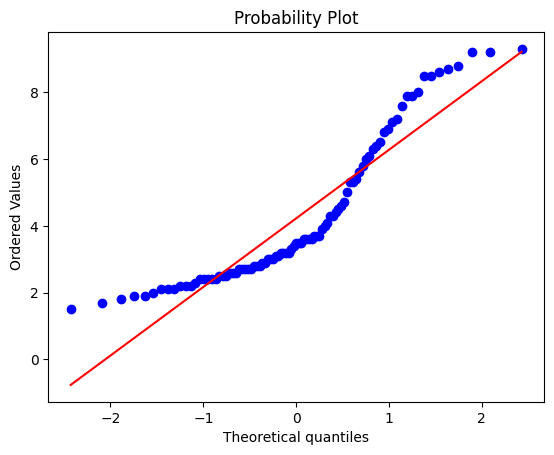

In [43]:
import scipy.stats
scipy.stats.probplot(joined['cpi'],dist='norm',plot=plt);

From the graph above we can conclude that the data is not normally distributed

In [44]:
#Linear Regression Model
#Used joined dataframe as it contains both target and independent variables
#divide data into independenent and dependent variables
X = pd.DataFrame(joined['cpi'])
y = pd.DataFrame(joined['epi'])

In [45]:
#imported train_test_split function in order to create training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [46]:
#the results of data split
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(72, 1)
(19, 1)
(72, 1)
(19, 1)


In [47]:
from sklearn.linear_model import LinearRegression
#the model is initialized
regressor = LinearRegression()
#the fit method uses the training data as an input to train the machine learning model
regressor.fit(X_train, y_train)

LinearRegression()

In [48]:
#the value of our target variable when all our features are zero and our function crosses the y-axis
print(regressor.intercept_)

[40.31775139]


In [49]:
#the model is trained, so we use predict method to get output values
y_pred = regressor.predict(X_test)
#created dataframe from predicted values
y_pred = pd.DataFrame(y_pred, columns = ['predicted'])

In [30]:
#reset indeces for both X_test and y_test dataframes in order to join them together
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)


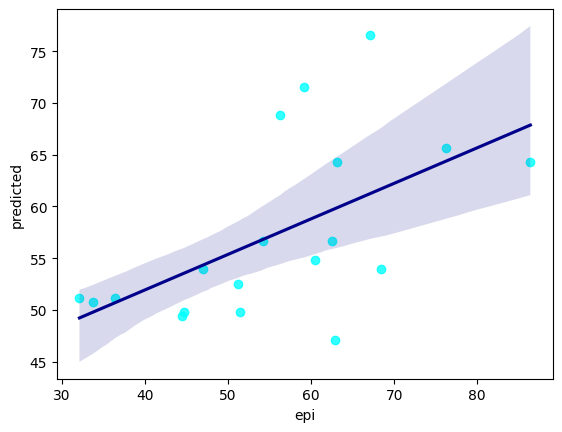

In [31]:
#data frame tha contains actual and predicted values
actual_predicted = X_test.join(y_test).join(y_pred)
#plot a graph of actual vs predicted values
sns.regplot(x='epi',y='predicted',data=actual_predicted, scatter_kws={'color': 'aqua'}, line_kws={'color':'darkblue'});


From the graph above we can see that most of points are far from regressed diagonal line. Thus the predictions the model produces are far from actual values.